In [22]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import json
import torch
import torch.nn as nn
from math import sin, cos, sqrt, atan2, radians
import copy
from sklearn.cluster import *
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import geopy.distance
from scipy.spatial.distance import *
import random
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import matplotlib.pyplot as plt


import python.data as data
import python.display as dp
import python.voxels as voxel
import python.metric as metric
import python.clustering as cl
import python.RNN as RNN
#import python.learning as learning
#from python.NN import *

project_folder = "veleval"

display = True
plt.style.use('seaborn-whitegrid')
graph_size = (13,6)

new_distance_matrix = True

save_dbscan_oservations = False

new_voxels_clustering = True
save_voxels_clustering = True





## Data Creation

In [2]:
data.mapmatching("files/"+project_folder+"/data_processed/observations.df", 
                 "files/"+project_folder+"/data_processed/observations_matched.df", 0)

In [3]:
data.simplify_gps("files/"+project_folder+"/data_processed/observations_matched.df", 
                  "files/"+project_folder+"/data_processed/observations_matched_simplified.df", 0)

In [4]:
if(project_folder == "monresovelo"):
    #data.check_file("files/"+project_folder+"/city_graphs/montreal.ox", ox.graph_from_place('montreal'))
    data.pathfinding_osmnx("files/"+project_folder+"/data_processed/observations_matched_simplified.df", 
                           "files/"+project_folder+"/data_processed/osmnx_pathfinding.df", 
                           "files/"+project_folder+"/city_graphs/montreal.ox", 0)

In [5]:
data.simplify_gps("files/"+project_folder+"/data_processed/osmnx_pathfinding.df", 
                  "files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df", 0)

## Distance

In [6]:
data.compute_distance("files/"+project_folder+"/data_processed/observations_matched_simplified.df",
                      "files/"+project_folder+"/distances/distances_observations.tab")
data.compute_distance("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df", 
                      "files/"+project_folder+"/distances/distances_osmnx.tab")

## Bikepath

In [7]:
#data.bikepath_fusion("files/"+project_folder+"/data_processed/osm_bikepath.df", 
#                     "files/"+project_folder+"/data_processed/bikepath_fusioned.df", 0)

# Data Loading

In [8]:
with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'rb') as infile:
    df_simplified = pickle.load(infile)
tab_routes_voxels_simplified, tab_routes_voxels_simplified_global, dict_voxels_simplified = voxel.generate_voxels(
    df_simplified, df_simplified.iloc[0]["route_num"], df_simplified.iloc[-1]["route_num"])

In [9]:
with open("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'rb') as infile:
    df_pathfinding = pickle.load(infile)
tab_routes_voxels_pathfinding, tab_routes_voxels_pathfinding_global, dict_voxels_pathfinding = voxel.generate_voxels(
    df_pathfinding, df_pathfinding.iloc[0]["route_num"], df_pathfinding.iloc[-1]["route_num"])


In [10]:
print(len(tab_routes_voxels_simplified))

899


In [11]:
'''with open("files/"+project_folder+"/data_processed/bikepath_fusioned.df", "rb") as outfile:
    df_bikepath = pickle.load(outfile)
    df_bikepath = pd.DataFrame(df_bikepath, dtype=object)

_, _, dict_voxels_bikepath = voxel.generate_voxels(df_bikepath, df_bikepath.iloc[0]["route_num"], df_bikepath.iloc[-1]["route_num"], True)'''

'with open("files/"+project_folder+"/data_processed/bikepath_fusioned.df", "rb") as outfile:\n    df_bikepath = pickle.load(outfile)\n    df_bikepath = pd.DataFrame(df_bikepath, dtype=object)\n\n_, _, dict_voxels_bikepath = voxel.generate_voxels(df_bikepath, df_bikepath.iloc[0]["route_num"], df_bikepath.iloc[-1]["route_num"], True)'

# Test voxels

In [12]:
map=None
if(display):
    num_vox = -1
    tab_vox = []
    num_route = 0
    df_display = df_simplified[df_simplified["route_num"]==num_route]
    df_display["type"] = 0
    for v in tab_routes_voxels_simplified[num_route]:
        vox_str = v.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_vox += voxel.get_voxel_points(vox_int, num_vox)
        num_vox -= 1

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, color="type")
map

/home/jupyter-lmagnana/.local/share/virtualenvs/cycling-predictive-model-PT9ZgGfn/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [13]:
if(display):
    with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'rb') as infile:
            df_simplified = pickle.load(infile)

    nb_routes = 1
    min_routes = 2
    df_simplified["type"] = 0
    df_display = df_simplified[(df_simplified["route_num"]<=nb_routes)]
    #print(df_display)
    _, _, dict_voxels = voxel.generate_voxels(df_display, 0, nb_routes)
    tab_vox = voxel.get_voxels_with_min_routes(dict_voxels, min_routes)
    print(len(tab_vox)/4)

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, color="type") 
    #print(tab_vox)
    #print(df)
    
map

11.0


# Heat Maps

In [14]:
if(display):     
    tab = []
    for key in dict_voxels_simplified:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_simplified[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)

    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_simplified.png")'''
map

In [15]:
if(display):
    tab = []
    for key in dict_voxels_pathfinding:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df[['lat', 'lon', 'Cyclability coefficient']].values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_mapbox.png")'''
map

In [16]:
if(display):
    tab_routes_voxels_common = []
    dict_voxels_common = {}
    tab = []

    for i in range(len(tab_routes_voxels_pathfinding_global)):
        tab_routes_voxels_common.append(list(set(tab_routes_voxels_pathfinding_global[i]).intersection(set(tab_routes_voxels_simplified_global[i]))))

    for i in range(len(tab_routes_voxels_common)):
        for key in tab_routes_voxels_common[i]:
            if key not in dict_voxels_common:
                dict_voxels_common[key] = [i]
            else:
                dict_voxels_common[key].append(i)

    for key in dict_voxels_common:
        tab_routes = dict_voxels_common[key]
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        if(len(tab_routes) >= 0):
            tab.append([vox_pos[0][0], vox_pos[0][1], len(tab_routes)])

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
    
#map

In [17]:
if(display):
    max_value = 0
    tab = []
    for key in dict_voxels_pathfinding:
        tab_routes = dict_voxels_pathfinding[key]["tab_routes_starting"]
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos =voxel. get_voxel_points(vox_int, 0)
        if(len(tab_routes) >= 0):
            tab.append([vox_pos[0][0], vox_pos[0][1], len(tab_routes)])
            if(len(tab_routes)>max_value):
                max_value+=1

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0.2, max_val = max_value).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
map

# Graphes distances

899


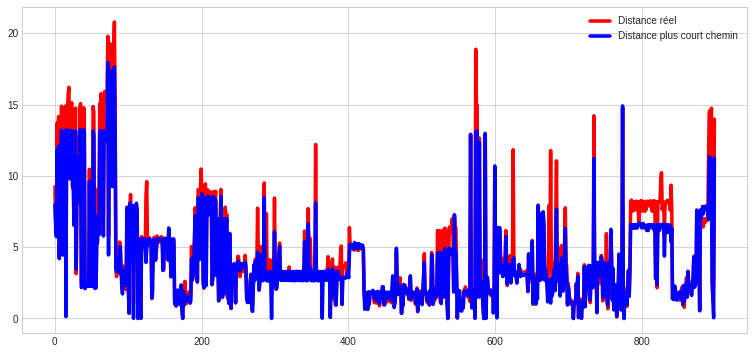

In [18]:
if(display):
    with open("files/"+project_folder+"/distances/distances_observations.tab",'rb') as infile:
        tab_distances = pickle.load(infile)    

    with open("files/"+project_folder+"/distances/distances_osmnx.tab",'rb') as infile:
        tab_distances_pf = pickle.load(infile)   

    print(len(tab_distances_pf))
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_pf), len(tab_distances_pf))
    plt.plot(x, tab_distances, color='red', linewidth=3.5, label='Distance réel')
    plt.plot(x, tab_distances_pf, color='blue', linewidth=3.5, label='Distance plus court chemin')
    
    plt.legend(loc='upper right')

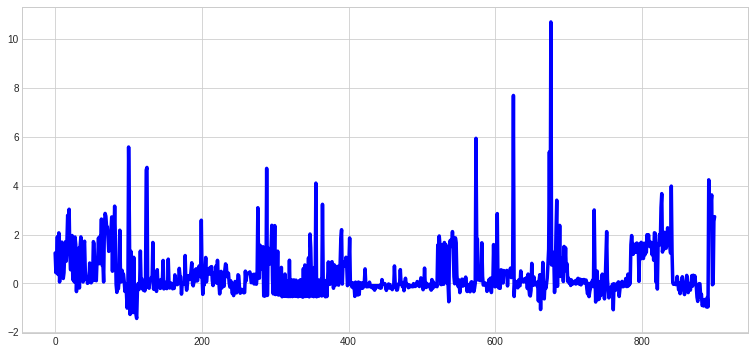

In [19]:
if(display):

    tab_distances_relatives = []
    for i in range(len(tab_distances)):
        tab_distances_relatives.append(tab_distances[i]-tab_distances_pf[i])
        
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_relatives), len(tab_distances_relatives))
    plt.plot(x, tab_distances_relatives, color='blue', linewidth=3.5)

# CDF

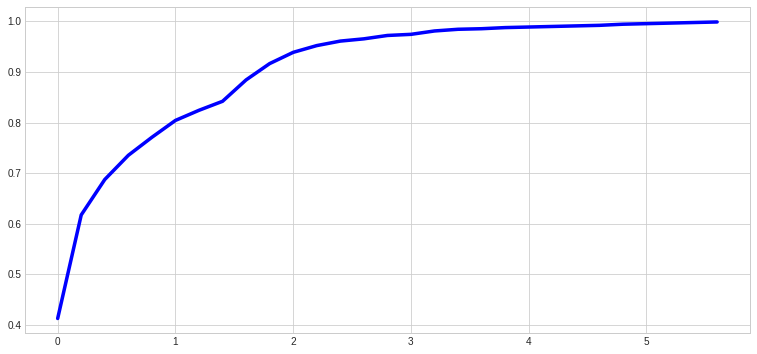

In [20]:
if(display):
    tab_distances_relatives.sort()
    tab_display = []
    tab_axis = []
    dist_max = 0
    nb_routes = 0
    for dist in tab_distances_relatives:
        if(dist > dist_max):
            tab_display.append(nb_routes/len(tab_distances_relatives))
            tab_axis.append(dist_max)
            dist_max += 0.2
        nb_routes += 1
        
        
        
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    plt.plot(tab_axis, tab_display, color='blue', linewidth=3.5)

# Matrice de distance

In [23]:
if(new_distance_matrix):
    distance_matrix = np.empty([df_simplified.iloc[-1]["route_num"]+1, df_simplified.iloc[-1]["route_num"]+1])

    pca = PCA(n_components=1)

    for i in range(df_simplified.iloc[-1]["route_num"]+1):

        for j in range(i, df_simplified.iloc[-1]["route_num"]+1):
            coeff = metric.get_distance_voxels(i, j, tab_routes_voxels_simplified_global)
            #coeff = metric.get_distance_euclidian(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1], pca)
            #coeff = metric.get_distance_hausdorff(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1])
            distance_matrix[i][j] = coeff[0]
            distance_matrix[j][i] = coeff[1]
    
    data.check_file("files/"+project_folder+"/clustering/distances_dbscan.mx", [])
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'wb') as outfile:
        pickle.dump(distance_matrix, outfile)
    
else:
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'rb') as infile:
        distance_matrix = pickle.load(infile)

print("number of non-zero in diag : ", len(np.nonzero(np.diagonal(distance_matrix))[0]))

number of non-zero in diag :  0


# Graphes clustering

In [24]:
start_variable = 0.1
stop_variable = 0.9
step_variable = 0.1

tab_nb_clusters = []
tab_noise = []
tab_nb_mini_clusters = []
tab_nb_big_clusters = []
tab_mean = []
tab_silhouette = []

for variable in np.arange(start_variable, stop_variable, step_variable):
    c = DBSCAN(eps=variable, min_samples=15, metric='precomputed')
    clusters = cl.cluster(distance_matrix, c)
    dict_cluster = cl.tab_clusters_to_dict(clusters)
    silhouette = silhouette_score(distance_matrix, clusters, metric="precomputed")

    nb_mini_clusters= 0
    nb_big_clusters = 0
    mean = 0
    for i in range(len(dict_cluster)-1):
        if(len(dict_cluster[i]) > 15):
            nb_big_clusters += 1
        elif(len(dict_cluster[i]) == 1):
            nb_mini_clusters += 1
        mean+=len(dict_cluster[i])
        
    tab_nb_clusters.append(len(dict_cluster)-1)
    tab_noise.append(clusters.tolist().count(-1))
    tab_nb_mini_clusters.append(nb_mini_clusters)
    tab_nb_big_clusters.append(nb_big_clusters)
    tab_mean.append(mean/(len(dict_cluster)-1))
    tab_silhouette.append(silhouette)
    


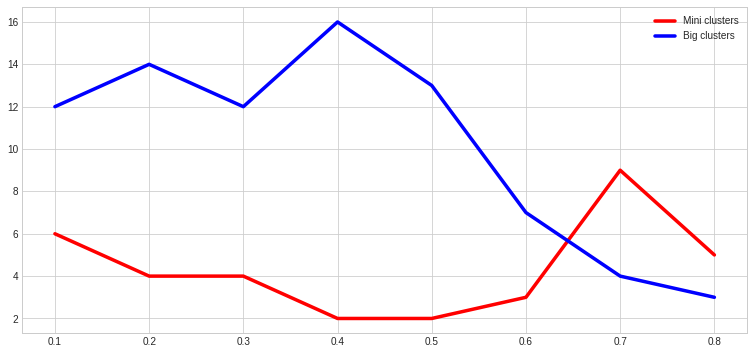

In [25]:
if(display):    
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_nb_mini_clusters, color='red', linewidth=3.5, label='Mini clusters')
    plt.plot(x, tab_nb_big_clusters, color='blue', linewidth=3.5, label='Big clusters')
    
    plt.legend(loc='upper right')

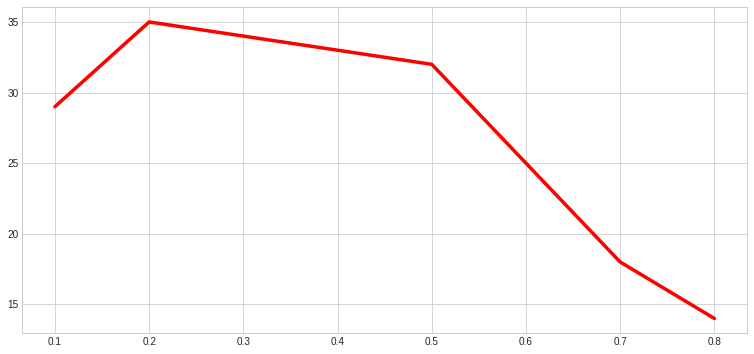

In [26]:
if(display):
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_nb_clusters, color='red', linewidth=3.5)

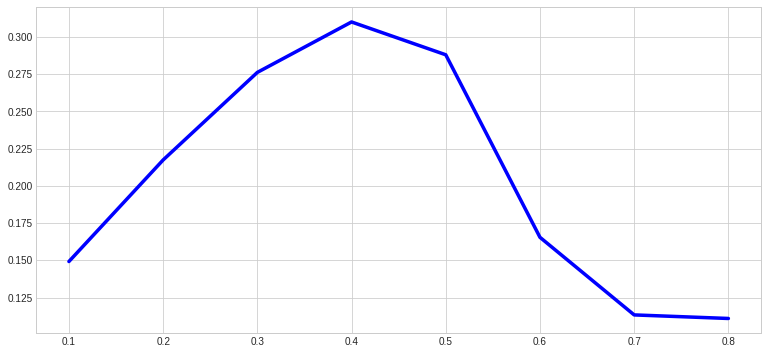

In [27]:
if(display):  
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_silhouette, color='blue', linewidth=3.5)

# Cluster Configuration

In [58]:
if (project_folder == "veleval"):
    config_clustering = {"eps": 0.4, "min_samples": 5, "n_clusters_divider": 10}
else:
    config_clustering = {"eps": 0.35, "min_samples": 10, "n_clusters_divider": 15}

# Observations Clustering

In [29]:
pca = PCA(n_components=750)
#distance_matrix_reduced = pca.fit_transform(distance_matrix)

dbscan = DBSCAN(eps=config_clustering["eps"], min_samples=config_clustering["min_samples"], metric='precomputed')
optics = OPTICS(min_samples=10, metric='precomputed')

clustering = dbscan
X = distance_matrix

tab_cluster = cl.cluster(X, clustering)
dict_cluster = cl.tab_clusters_to_dict(tab_cluster)

print(len(dict_cluster)-1, "clusters")
print("noise:", tab_cluster.tolist().count(-1))
print()
cl.cluster_properties(dict_cluster, distance_matrix, tab_cluster, "precomputed")

74 clusters
noise: 81

silhouette score : 0.38988872319145457

mean size : 11.054054054054054

16 big clusters: [0, 1, 4, 46, 18, 30, 12, 16, 19, 24, 45, 29, 33, 35, 36, 62]
11 mini clusters : [2, 5, 6, 38, 48, 53, 55, 56, 60, 64, 71]


In [30]:
if(save_dbscan_oservations):
    print("Saving DBSCAN observations...")
    with open("files/"+project_folder+"/clustering/dbscan_observations.dict",'wb') as outfile:
        pickle.dump(dict_cluster, outfile)
    with open("files/"+project_folder+"/clustering/dbscan_observations.tab",'wb') as outfile:
        pickle.dump(tab_cluster, outfile)

In [31]:
df_simplified

,lat,lon,route_num,type
0,45.7598,4.87564,0,0
1,45.7595,4.87557,0,0
2,45.7594,4.87589,0,0
3,45.7583,4.87658,0,0
4,45.7561,4.87612,0,0
...,...,...,...,...
61,45.7785,4.80798,898,0
62,45.7805,4.80921,898,0
63,45.7806,4.80916,898,0
64,45.7827,4.81093,898,0


In [32]:
if(display):
    num_cluster = 0
    print(len(dict_cluster[num_cluster]))
    #dp.display_routes(df_simplified, dict_cluster[nb_cluster])
    map = dp.display_cluster_heatmap(df_simplified, dict_cluster[num_cluster])
map

21


/home/jupyter-lmagnana/cycling-predictive-model/python/display.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["num_route"] = i


# Voxel Clustering

In [33]:
'''clusters_used = []
for key in dict_voxels_bikepath:
    if key in dict_voxels_pathfinding:
        if(dict_voxels_bikepath[key]["cluster"] not in clusters_used):
            dict_voxels_pathfinding[key]["cluster"] = len(clusters_used)
            clusters_used.append(dict_voxels_bikepath[key]["cluster"])
        else:
            dict_voxels_pathfinding[key]["cluster"] = clusters_used.index(dict_voxels_bikepath[key]["cluster"])'''

'clusters_used = []\nfor key in dict_voxels_bikepath:\n    if key in dict_voxels_pathfinding:\n        if(dict_voxels_bikepath[key]["cluster"] not in clusters_used):\n            dict_voxels_pathfinding[key]["cluster"] = len(clusters_used)\n            clusters_used.append(dict_voxels_bikepath[key]["cluster"])\n        else:\n            dict_voxels_pathfinding[key]["cluster"] = clusters_used.index(dict_voxels_bikepath[key]["cluster"])'

In [59]:
X = []
for key in dict_voxels_pathfinding:
    if("cluster" not in dict_voxels_pathfinding[key]):
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_points = voxel.get_voxel_points(vox_int)
        X.append([tab_points[0][0], tab_points[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])
print(len(X))

10813


In [60]:
if(new_voxels_clustering):  
    kmeans = KMeans(n_clusters=len(X)//config_clustering["n_clusters_divider"], random_state=0)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = cl.cluster(X, kmeans)

else:
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'rb') as infile:
        kmeans = pickle.load(infile)
    clusters = kmeans.labels_
        
dict_cluster_voxel = cl.tab_clusters_to_dict(clusters)

cl.cluster_properties(dict_cluster_voxel, X, clusters)
print(len(dict_cluster_voxel)-1, "clusters")
print("noise:", clusters.tolist().count(-1))
print()


silhouette score : 0.5476918198210001

mean size : 10.012037037037038

0 big clusters: []
1021 mini clusters : [695, 996, 525, 793, 687, 990, 358, 822, 1015, 545, 460, 692, 596, 45, 680, 265, 352, 1021, 119, 2, 634, 740, 1047, 270, 881, 976, 38, 844, 722, 606, 801, 536, 897, 142, 899, 446, 129, 34, 204, 362, 1074, 926, 183, 235, 573, 622, 406, 540, 557, 347, 718, 19, 1058, 428, 610, 975, 924, 229, 335, 384, 498, 551, 58, 207, 308, 725, 520, 643, 567, 888, 135, 800, 648, 488, 281, 830, 139, 572, 152, 1017, 763, 259, 1043, 353, 578, 378, 436, 1023, 60, 36, 957, 766, 300, 853, 336, 1020, 813, 474, 339, 913, 744, 788, 1035, 743, 146, 236, 462, 936, 984, 880, 423, 614, 64, 760, 1037, 395, 941, 331, 908, 87, 669, 262, 811, 741, 227, 982, 892, 163, 867, 904, 495, 496, 29, 189, 374, 294, 410, 716, 1011, 481, 40, 699, 1060, 125, 775, 859, 470, 415, 1056, 68, 506, 458, 177, 995, 564, 199, 394, 726, 6, 792, 79, 959, 1036, 14, 666, 877, 285, 360, 621, 947, 216, 638, 814, 340, 734, 835, 338, 1006, 

In [61]:
if(save_voxels_clustering):
    print("Saving kmeans_voxels_osmnx.sk...")
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'wb') as outfile:
        pickle.dump(kmeans, outfile)

Saving kmeans_voxels_osmnx.sk...


In [62]:
if(display):

    num_cluster = 792

    tab = []
    for vox in dict_cluster_voxel[num_cluster]:
        tab.append(X[vox])

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), radius=8, max_zoom=13).add_to(map)
    
map
    
    
    

In [63]:
dict_voxels_pathfinding_clustered = deepcopy(dict_voxels_pathfinding)
for c in dict_cluster_voxel:
    for vox in dict_cluster_voxel[c]:
        v = X[vox]
        vox_int = voxel.find_voxel_int([v[0], v[1]], False)
        key = str(vox_int[0])+";"+str(vox_int[1])
        dict_voxels_pathfinding_clustered[key]["cluster"] = c #len(clusters_used)+c
if(save_voxels_clustering):
    print("Saving voxels_clustered_osmnx.dict...")
    with open("files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'wb') as outfile:
        pickle.dump(dict_voxels_pathfinding_clustered, outfile)

Saving voxels_clustered_osmnx.dict...


In [48]:
print(len(dict_voxels_pathfinding_clustered))

10813


# Osmnx

In [ ]:
with open("files/"+project_folder+"/clustering/dbscan_observations.tab",'rb') as infile:
    tab_clusters = pickle.load(infile)
print(df_pathfinding.iloc[-1]["route_num"], tab_clusters[df_pathfinding.iloc[-1]["route_num"]])

In [ ]:
#G_lyon = ox.graph_from_point((45.74846, 4.84671), dist=7500)
#G_stetienne = ox.graph_from_point((45.4333, 4.4), dist=7500)
#G_montreal = ox.graph_from_place('montreal')

In [ ]:
with open("files/"+project_folder+"/city_graphs/city.ox", "rb") as infile:
    G = pickle.load(infile)

nodes, _ = ox.graph_to_gdfs(G)
tree = KDTree(nodes[['y', 'x']], metric='euclidean')

# Validation

In [ ]:
import os
if(not(os.path.isfile("files/"+project_folder+"/neural_networks/network_osmnx.pt"))):
    print("No neural network found.")
    
else:
    print("Testing neural network...")
    import python.validation as validation

    with open("files/"+project_folder+"/clustering/dbscan_observations.tab",'rb') as infile:
        tab_clusters = pickle.load(infile)
    with open("files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'rb') as infile:
        dict_voxels = pickle.load(infile)
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'rb') as infile:
        kmeans = pickle.load(infile)

    df = df_pathfinding

    size_data = 1
    hidden_size = 256
    num_layers = 2
    voxels_frequency = 4

    network = RNN.RNN_LSTM(size_data, max(tab_clusters)+1, hidden_size, num_layers)
    network.load_state_dict(torch.load("files/"+project_folder+"/neural_networks/network_osmnx.pt"))
    network.eval()

    nb_good_predict = 0
    nb_predict = 0

    deviation = 0 #5e-3

    tab_predict = []

    for i in range(10): #len(tab_clusters)):
        if(tab_clusters[i] != -1):
            #print(i)
            df_temp = df[df["route_num"]==i]
            d_point = [df_temp.iloc[0]["lat"], df_temp.iloc[0]["lon"]]
            f_point = [df_temp.iloc[-1]["lat"], df_temp.iloc[-1]["lon"]]
            rand = random.uniform(-deviation, deviation)
            d_point[0] += rand
            rand = random.uniform(-deviation, deviation)
            d_point[1] += rand
            rand = random.uniform(-deviation, deviation)
            f_point[0] += rand
            rand = random.uniform(-deviation, deviation)
            f_point[1] += rand

            if(d_point[0] > 45.5 or project_folder != "veleval"):
                df_route, cl, nb_new_cluster = validation.find_cluster(d_point, f_point, network, voxels_frequency, df_pathfinding, dict_voxels, 
                                             kmeans, tree, G, False)
                if(cl == tab_clusters[i]):
                    nb_good_predict += 1
                    #print("good predict")
                nb_predict += 1
    if(nb_predict > 0):
        tab_predict.append(nb_good_predict/nb_predict)

    tot_predict = 0
    for predict in tab_predict:
        tot_predict += predict
    print("ratio:", tot_predict/len(tab_predict))


In [ ]:
dp.display(df_route)

In [ ]:
dp.display(df_pathfinding[df_pathfinding["route_num"]==1])

# Graph modification

In [ ]:
#G_stetienne
G = G_lyon
with open("files/"+project_folder+"/bikepath_fusioned.df", "rb") as outfile:
    df_osm_bikepath = pickle.load(outfile)
    df_osm_bikepath = pd.DataFrame(df_osm_bikepath, dtype=object)
      
_, dict_voxels_osm_bikepath = voxel.generate_voxels(df_osm_bikepath, df_osm_bikepath.iloc[0]["route_num"], df_osm_bikepath.iloc[-1]["route_num"], True)

for v in G:
    for v_n in G[v]:
        df_line = pd.DataFrame([[G.nodes[v]['y'], G.nodes[v]['x'], 1], [G.nodes[v_n]['y'], G.nodes[v_n]['x'], 1]], columns=["lat", "lon", "route_num"])
        tab_voxels, _ = voxel.generate_voxels(df_line, 1, 1)
        nb_vox_found = 0
        tot_coeff = 0
        for vox in tab_voxels[0]:
            if vox in dict_voxels_osm_bikepath:
                G[v][v_n][0]['length'] -= G[v][v_n][0]['length']*0.15
                break

In [ ]:
with open("files/"+project_folder+"/data_processed/dbscan_pathfinding_osmnx.dict",'rb') as infile:
    dict_cluster = pickle.load(infile)
    
new_dict = {}
    
for key in dict_cluster:
    print(dict_cluster[key])

    